In [1]:
# ==== Core ====
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ==== Viz ====
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ==== Stats / Transforms ====
from scipy.special import boxcox1p
from mplfinance.original_flavor import candlestick_ohlc

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
os.chdir(r'/workspace/project/upstage-ml-regression-sigma7/data')

In [4]:
# load data
train_file = r'train.csv'
test_file = r'test.csv'
train = pd.read_csv(train_file, encoding= 'utf-8')
test = pd.read_csv(test_file, encoding= 'utf-8')
bus = pd.read_csv('bus_feature.csv', encoding= 'utf-8')
subway = pd.read_csv('subway_feature.csv', encoding= 'utf-8')
print('train 데이터입니다.')
train


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [11]:
# train, test 데이터 합치기
train['train_data'] = 1
test['train_data'] = 0

train  = pd.concat([train, test]).reset_index(drop=True)

In [12]:
# 계약년월 -> 계약년, 계약월
train['계약년월'] = pd.to_datetime(train['계약년월'], format='%Y%m' )

train['계약년'] = train['계약년월'].dt.year
train['계약월'] = train['계약년월'].dt.month

train.drop('계약년월', axis=1, inplace=True)

In [13]:
# 전용면적(㎡) -> 전용면적
train = train.rename(columns={'전용면적(㎡)':'전용면적'})


In [14]:
# 결측치 확인
print('* 결측치가 100만개 이하인 변수들 :', list(train.columns[train.isnull().sum() <= 1000000]))     

print('* 결측치가 100만개 이상인 변수들 :', list(train.columns[train.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'train_data', '계약년', '계약월']
* 결측치가 100만개 이상인 변수들 : []


In [15]:
# 결측치 확인
train.isnull().sum().sort_values(ascending=False)

k-135㎡초과                  349150
해제사유발생일                   344396
k-등록일자                    342628
단지소개기존clob                328487
k-홈페이지                    312879
고용보험관리번호                  287369
세대전기계약방법                  274069
k-팩스번호                    271931
k-시행사                     271459
청소비관리형태                   271447
k-건설사(시공사)                271410
경비비관리형태                   271407
k-단지분류(아파트,주상복합등등)        271299
k-전체동수                    271268
단지승인일                     271229
k-전화번호                    271158
k-복도유형                    271017
건축면적                      270931
주차대수                      270929
k-사용검사일-사용승인일             270925
좌표X                       270924
좌표Y                       270924
단지신청일                     270908
k-수정일자                    270896
k-85㎡~135㎡이하              270896
k-전용면적별세대현황(60㎡~85㎡이하)    270896
k-전용면적별세대현황(60㎡이하)        270896
k-주거전용면적                  270895
k-관리비부과면적                 270880
기타/의무/임대/임의=1/2/3/4       270880
사용허가여부    

In [16]:
# 전용면적 비
total = (
train['k-전용면적별세대현황(60㎡이하)'].fillna(0) +
train['k-전용면적별세대현황(60㎡~85㎡이하)'].fillna(0) +
train['k-85㎡~135㎡이하'].fillna(0) +
train['k-135㎡초과'].fillna(0)
)

train['소형비율'] = train['k-전용면적별세대현황(60㎡이하)'] / total
train['중소형비율'] = train['k-전용면적별세대현황(60㎡~85㎡이하)'] / total
train['중대형비율'] = train['k-85㎡~135㎡이하'] / total
train['대형비율'] = train['k-135㎡초과'] / total

In [17]:
# 불필요한 변수 제거
train.drop(['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지',
             'k-등록일자','k-85㎡~135㎡이하','k-전용면적별세대현황(60㎡~85㎡이하)',
             'k-전용면적별세대현황(60㎡이하)'], axis=1, inplace=True)

In [18]:
# 연속형, 범주형 변수 구분
continuous_columns = []
categorical_columns = []

for column in train.columns:
    if pd.api.types.is_numeric_dtype(train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '대형비율']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [19]:
# 복제
train_main = train.copy()

In [20]:
# 불필요한 변수 제거
train_main.drop(['대형비율', '고용보험관리번호', 'k-팩스번호', 'k-전화번호', 'k-수정일자','k-시행사','관리비 업로드','사용허가여부','중개사소재지','등기신청일자'],axis=1, inplace=True)

In [21]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

세대전기계약방법               274069
청소비관리형태                271447
k-건설사(시공사)             271410
경비비관리형태                271407
중대형비율                  271406
중소형비율                  271406
소형비율                   271406
k-단지분류(아파트,주상복합등등)     271299
k-전체동수                 271268
단지승인일                  271229
k-복도유형                 271017
건축면적                   270931
주차대수                   270929
k-사용검사일-사용승인일          270925
좌표X                    270924
좌표Y                    270924
단지신청일                  270908
k-주거전용면적               270895
기타/의무/임대/임의=1/2/3/4    270880
k-관리비부과면적              270880
k-연면적                  270879
k-난방방식                 270879
k-관리방식                 270879
k-세대타입(분양형태)           270879
k-전체세대수                270879
target                   9273
아파트명                      883
번지                         94
본번                         26
부번                         26
계약월                         0
계약년                         0
train_data                  0
계약일       

In [22]:
# 결측치 0으로 채우기
train_main[['중대형비율','중소형비율','소형비율']].fillna(0, inplace=True)

In [23]:
# '시군구' value 확인
train_main['시군구'].value_counts()

서울특별시 노원구 상계동      15026
서울특별시 노원구 중계동       8943
서울특별시 구로구 구로동       8087
서울특별시 도봉구 창동        7367
서울특별시 관악구 봉천동       7085
                   ...  
서울특별시 용산구 갈월동          2
서울특별시 성북구 동선동5가        2
서울특별시 종로구 명륜3가         2
서울특별시 마포구 구수동          1
서울특별시 중구 남산동2가         1
Name: 시군구, Length: 338, dtype: int64

In [24]:
# '시군구' -> '구', '동' 분리
train_main['구'] = train_main['시군구'].apply(lambda x: str(x).split(' ')[1] if len(str(x).split(' ')) > 1 else '기타')
train_main['동'] = train_main['시군구'].apply(lambda x: str(x).split(' ')[2] if len(str(x).split(' ')) > 2 else '기타')
train_main.drop('시군구', axis=1, inplace=True)

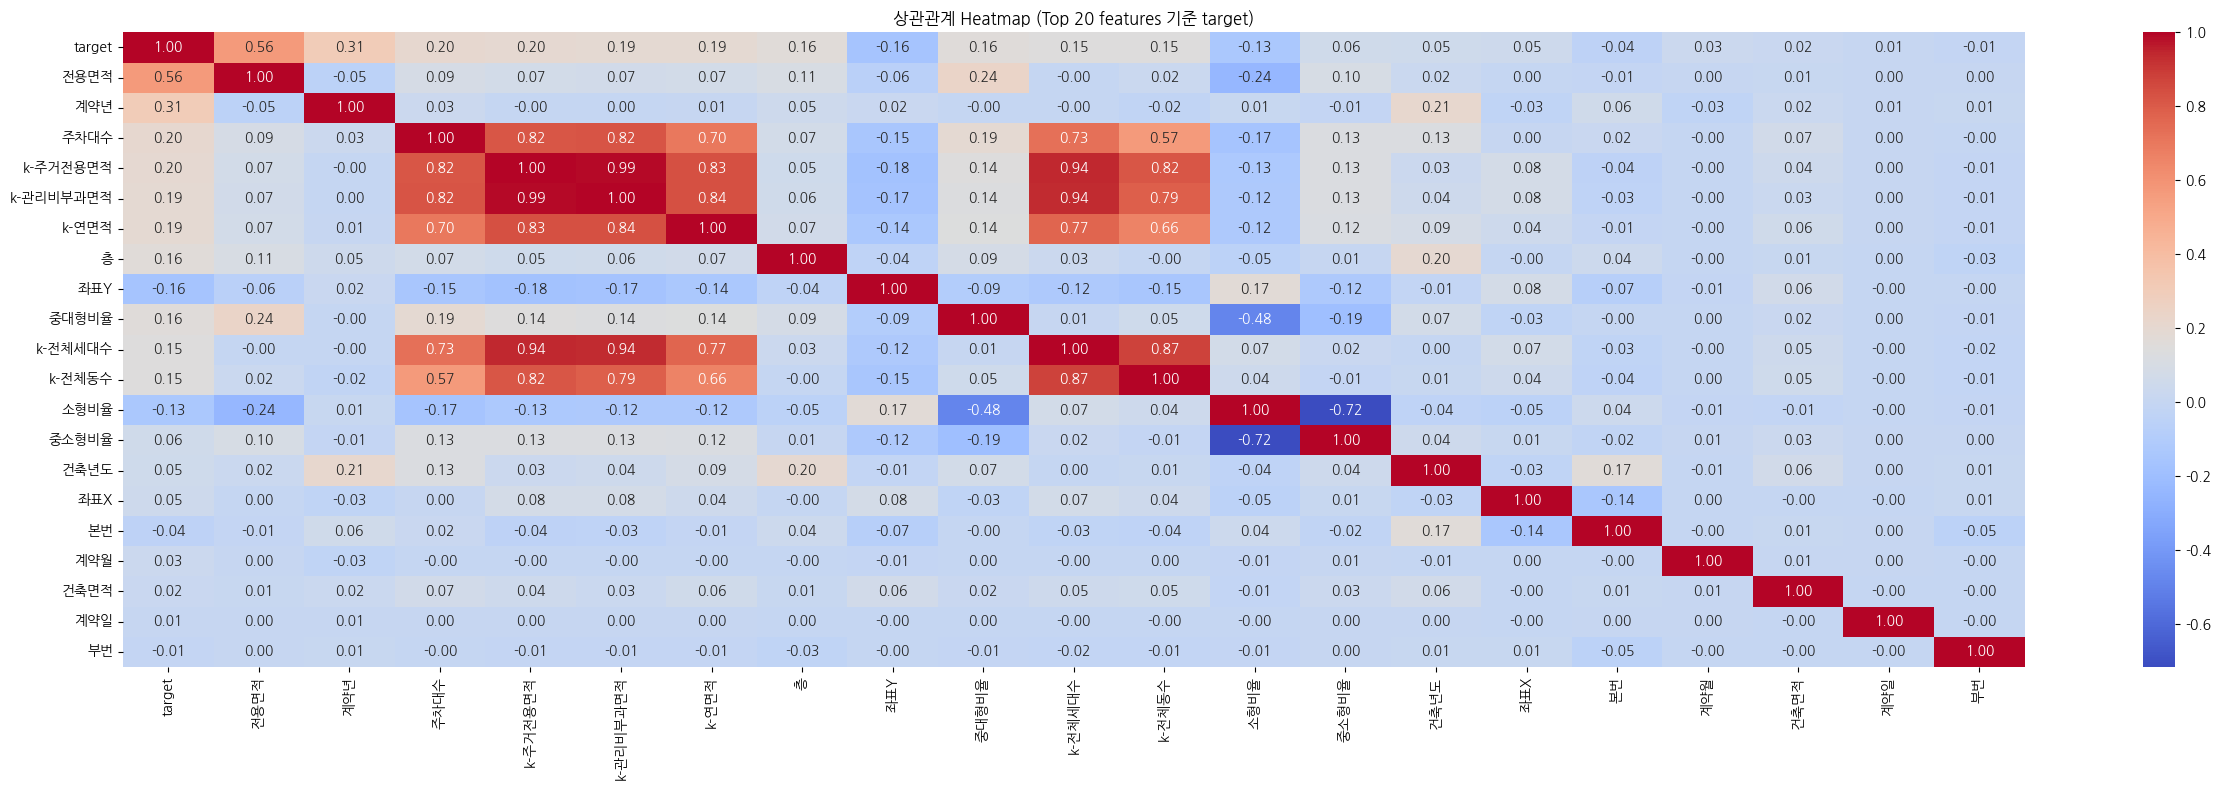

In [25]:
# 한글 폰트 설정
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

def plot_corr_heatmap(df, target_col="target", train_flag_col="train_data", topn=20):
    """
    - train 데이터만 사용
    - 수치형 변수의 target과 상관관계 계산
    - 상위 N개 변수 + target으로 heatmap 시각화
    """
    # train만 필터링
    dtrain = df[df[train_flag_col] == 1].copy()
    
    # 수치형 변수만 선택
    num_cols = dtrain.select_dtypes(include=["number"]).columns.tolist()
    if target_col in num_cols:
        pass
    else:
        num_cols.append(target_col)

    # 결측치 중앙값 대체 (상관 안정화)
    dnum = dtrain[num_cols].copy()
    dnum = dnum.fillna(dnum.median())

    # 상관계수 행렬
    corr = dnum.corr()

    # target과 상관 높은 상위 N 변수 선택
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    top_features = target_corr.head(topn+1).index.tolist()  # target 포함

    # Heatmap 그리기
    plt.figure(figsize=(1.2*len(top_features), 8))
    sns.heatmap(corr.loc[top_features, top_features], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"상관관계 Heatmap (Top {topn} features 기준 {target_col})")
    plt.tight_layout()
    plt.show()

# ======================
# 사용 예시
# ======================
plot_corr_heatmap(train_main, target_col="target", train_flag_col="train_data", topn=20)

In [26]:
# 상관계수 확인 후 상관계수 높은 변수 확인 
train_main['k-주거전용면적'].value_counts()

353089.0    898
405926.0    883
117086.0    864
470140.0    848
537573.0    804
           ... 
54610.0       2
10403.0       2
18236.0       2
22782.0       1
2796.0        1
Name: k-주거전용면적, Length: 740, dtype: int64

In [27]:
# 비슷한 변수 제거
train_main.drop(['k-관리비부과면적','k-주거전용면적',], axis=1, inplace =True)

In [28]:
# 신축여부 변수 생
train_main['신축여부'] = train_main['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [29]:
# 서울 집값 등급 변수 생성
price_group = {
    "강남구": 3, "서초구": 3, "송파구": 3, "용산구": 3,
    "마포구": 2, "성동구": 2, "광진구": 2, "동작구": 2, "양천구": 2, "강동구": 2,
}
train_main["서울집값등급"] = train_main["구"].map(price_group).fillna(1)

In [30]:
# 서울집값등급 value 확인
train_main['서울집값등급'].value_counts()

1.0    204191
2.0     78524
3.0     66573
Name: 서울집값등급, dtype: int64

In [31]:
# 좌표 변수 제거
train_main['경도'] =  train_main['좌표X']
train_main['위도'] =  train_main['좌표Y']
train_main.drop(['좌표X','좌표Y'], axis=1, inplace=True)

In [32]:
# 아파트명 value 확인
train_main['아파트명'].value_counts()

현대               5028
신동아              4032
한신               2698
두산               2427
우성               2357
                 ... 
초원탑스빌               1
양재동현대               1
글로벌파크               1
하영                  1
힐스테이트세운센트럴1단지       1
Name: 아파트명, Length: 6318, dtype: int64

In [33]:
# 아파트 브랜드 등급 변수 생성
import re
import pandas as pd

# === 1) 우선순위 패턴 목록 (위에서 아래로 매칭) ===
# (정규식 패턴, 등급)
PATTERN_GRADED = [

    # ---- 5등급: 최상위 랜드마크/초고가 ----
    (r'한남더힐', 5),
    (r'나인원\s*한남|Nine\s*One\s*Hannam', 5),
    (r'PH\s*129|PH129', 5),
    (r'아크로\s*서울\s*포레스트|Acro\s*Seoul\s*Forest', 5),
    (r'아크로\s*리버\s*파크|Acro\s*River\s*Park', 5),

    # ---- 4등급: 강남권 최상위/프리미엄 플래그십 ----
    (r'원\s*베일리|원베일리|래미안\s*원\s*베일리', 4),
    (r'반포\s*자이', 4),
    (r'래미안\s*퍼스티지', 4),
    (r'압구정.*현대|현대.*압구정', 4),
    (r'디\s*에이치|THE\s*H|The\s*H', 4),             # 현대 고급 브랜드 (예: 디에이치 아너힐즈 등)
    (r'트리마제|Trimage', 4),
    (r'라클래시|래미안\s*라\s*클래시|Raemian\s*Laclass', 4),

    # ---- 3등급: 메이저 브랜드 일반/강남권 대단지 ----
    (r'래미안|Raemian', 3),
    (r'자이|Xi\b', 3),
    (r'아이\s*파크|I-?PARK|IPARK', 3),
    (r'푸르지오|Prugio', 3),
    (r'더\s*샵|The\s*Sharp', 3),
    (r'e\s*편한\s*세상|e편한세상|e-?Pyeonhansesang', 3),
    (r'센트레빌', 3),
    (r'래대푸|마포\s*래미안\s*푸르지오', 3),
    (r'헬리오\s*시티|Helio\s*City', 3),
    (r'파크리오', 3),
    (r'올림픽\s*선수촌', 3),
    (r'잠실\s*(리센츠|엘스|트리지움)', 3),

    # ---- 2등급: 준메이저/중상 브랜드, 대중적 신축/재건축 ----
    (r'힐스테이트|Hillstate', 2),
    (r'롯데\s*캐슬|Lotte\s*Castle', 2),
    (r'위브|We\'?ve', 2),
    (r'호반\s*(써밋|베르디움)', 2),
    (r'경남\s*아너스빌|아너스빌', 2),
    (r'두산', 2),
    (r'금호', 2),
    (r'벽산', 2),
    (r'현대\s*홈\s*타운', 2),

    # ---- 1등급: 기타/브랜드 미표기/중소 ----
    # 매칭 없으면 1로 처리
]

def brand_grade_from_name(name: str) -> int:
    """아파트명 문자열에서 브랜드/단지 키워드를 정규식으로 찾아 5~1등급 반환."""
    if pd.isna(name):
        return 1
    s = str(name).strip()
    # 공백/하이픈/대소문자 변형 허용을 위한 전처리(선택): 여기서는 정규식이 유연해서 생략 가능
    for pattern, grade in PATTERN_GRADED:
        if re.search(pattern, s, flags=re.IGNORECASE):
            return int(grade)
    return 1

# 사용 예시
train_main['apt_grade'] = train_main['아파트명'].apply(brand_grade_from_name).astype(int)



In [34]:
# 아파트 브랜드 등급 value 확인
train_main['apt_grade'].value_counts()

1    272071
3     42327
2     32957
4      1523
5       410
Name: apt_grade, dtype: int64

In [35]:
# apt_grade 1~5 -> 1,2,3(보통),3(보통),3(보통) 으로 변환
bins_map_A = {1:1, 2:2, 3:3, 4:3, 5:3}
train_main['apt_grade_bin_A'] = train_main['apt_grade'].map(bins_map_A).astype('Int64')

train_main['is_ultra_premium'] = train_main['apt_grade'].isin([4,5]).astype(int)
# apt_grade 자체(1~5) + is_ultra_premium(0/1) 병행


In [36]:
# 아파트명 변수 제거
train_main.drop('apt_grade',axis=1, inplace=True)

In [37]:
# 불필요한 변수 제거
train_main.drop(['번지','본번','아파트명', '부번', '도로명', '거래유형'],axis=1, inplace=True)

In [38]:
# 건설사 value 확인
train_main['k-건설사(시공사)'].value_counts()

삼성물산         4289
대우건설         3827
현대건설         3272
GS건설         2492
대한주택공사       2380
             ... 
두산              5
대림건설(주)         5
신영건설            3
자이에스앤디(주)       2
혜림건설            1
Name: k-건설사(시공사), Length: 343, dtype: int64

In [39]:
# 건설사 변수 생성
# 건설사 등급 점수 매핑 (3: 대형, 2: 중견, 1: 기타)
company_score_3 = {
    '삼성물산': 3,
    '현대건설': 3,
    'GS건설': 3,
    'DL이앤씨': 2,
    'HDC현대산업개발': 2,
    '대우건설': 2,
    '포스코건설': 2,
    '롯데건설': 2,
    '호반건설': 1,
    '금호건설': 1,
    '쌍용건설': 1,
    '두산건설': 1,
}

def match_company_score(name: str) -> int:
    if pd.isna(name):
        return 1  # 결측치 -> 기타
    for comp, score in company_score_3.items():
        if re.search(comp, str(name)):
            return score
    return 1  # 어떤 회사명도 매칭 안 되면 '기타' = 1

train_main['건설사구분'] = train_main['k-건설사(시공사)'].apply(match_company_score).astype(int)


In [40]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns= []
categorical_columns = []
for column in train_main.columns:
    if pd.api.types.is_numeric_dtype(train_main[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', '건축면적', '주차대수', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분']
범주형 변수: ['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일', '구', '동']


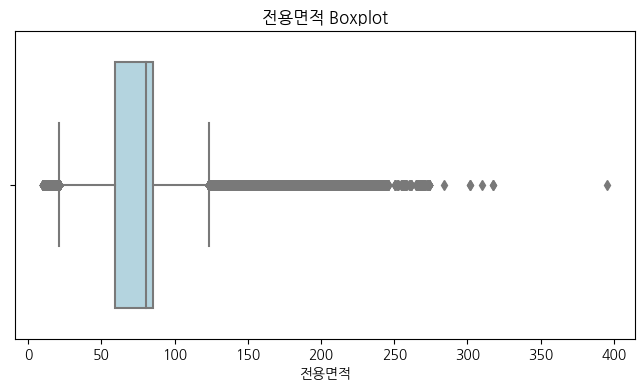

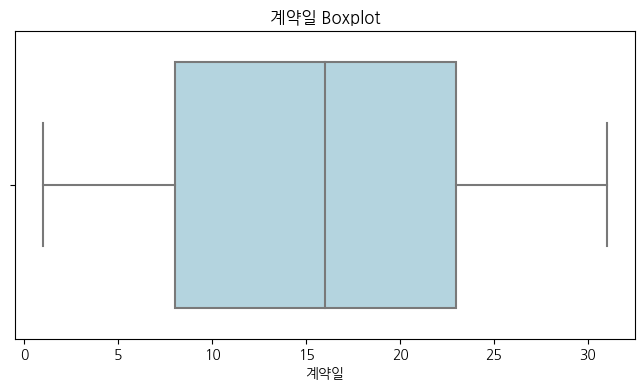

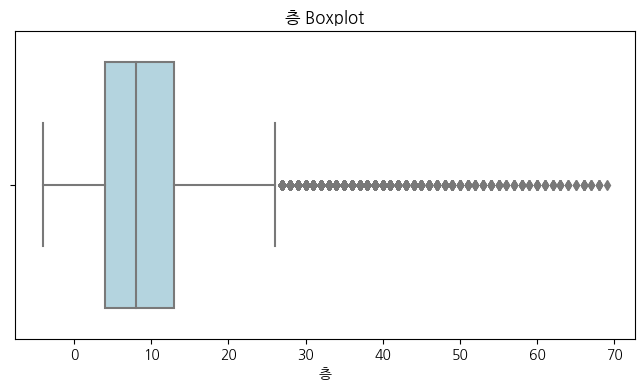

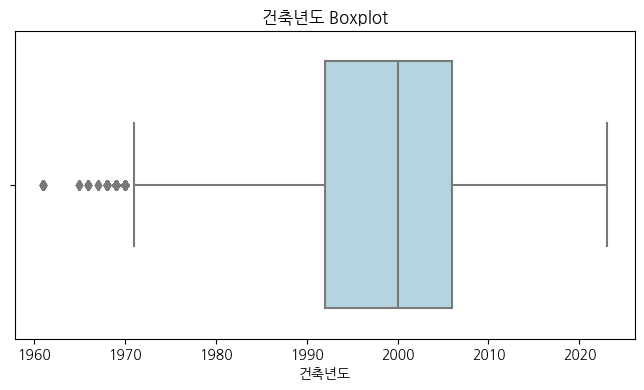

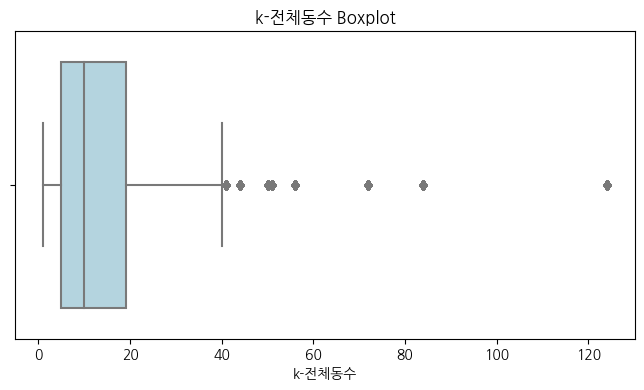

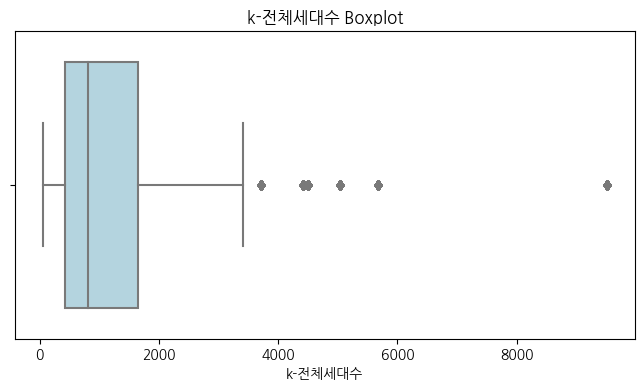

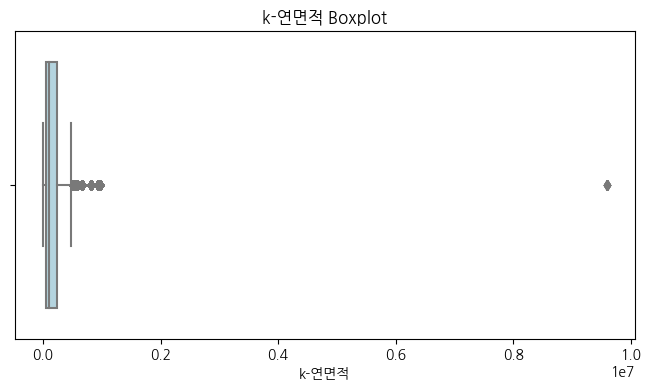

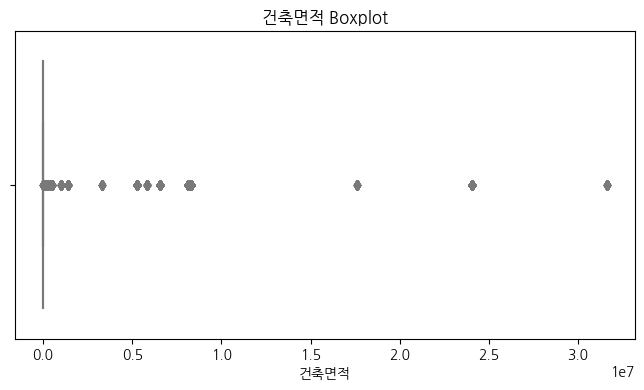

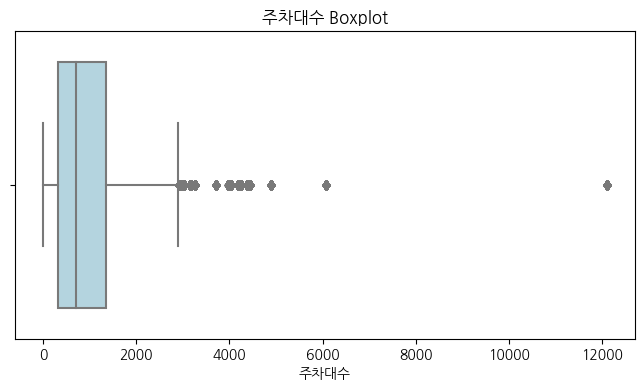

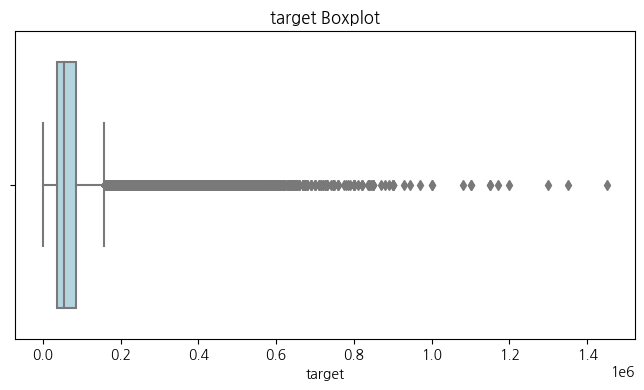

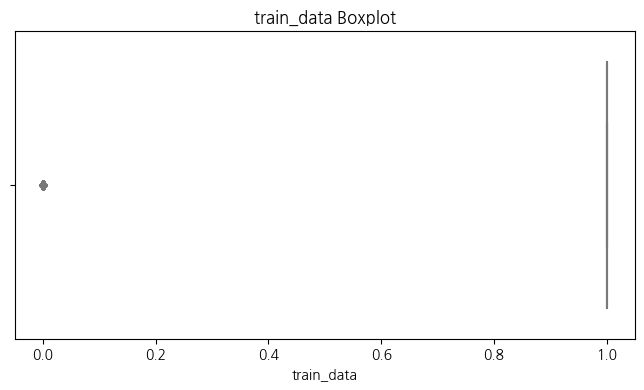

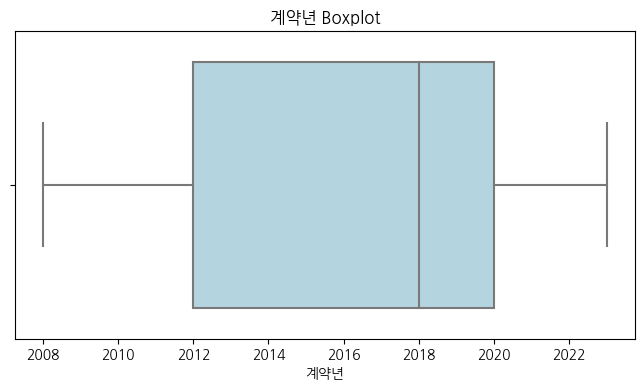

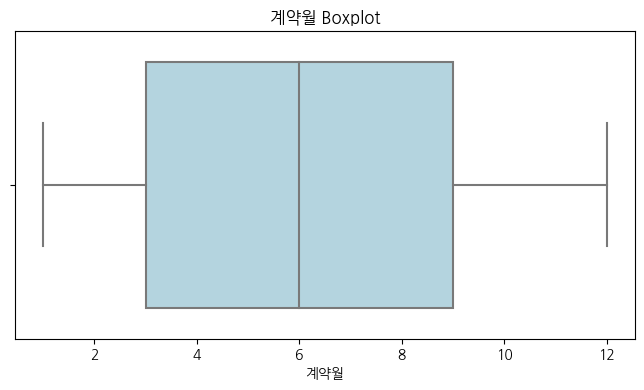

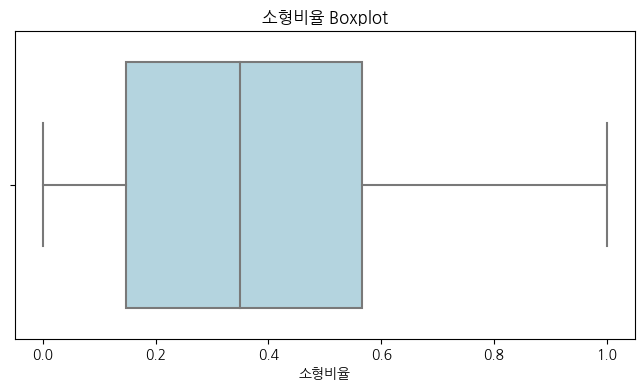

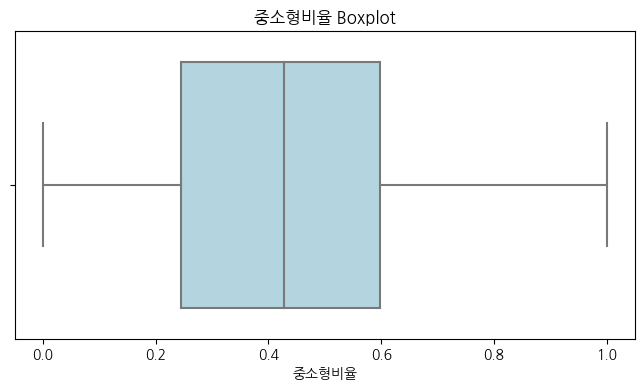

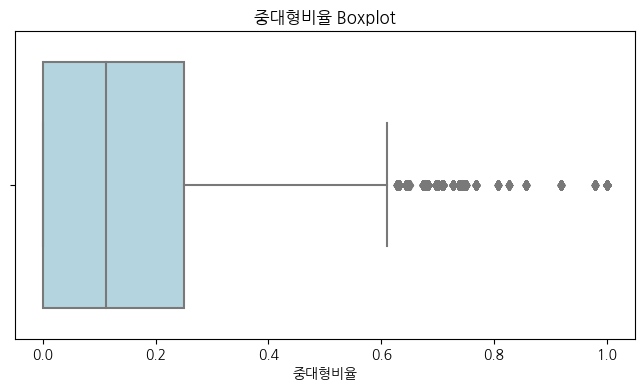

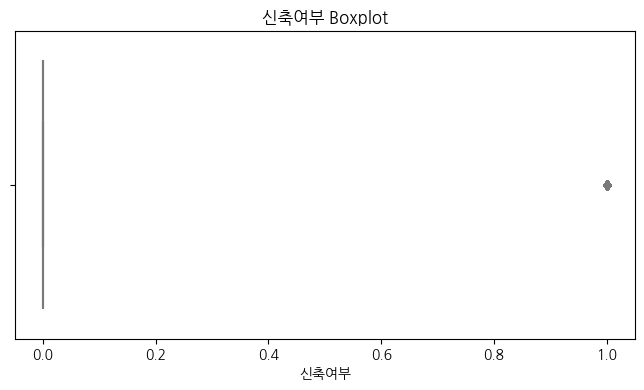

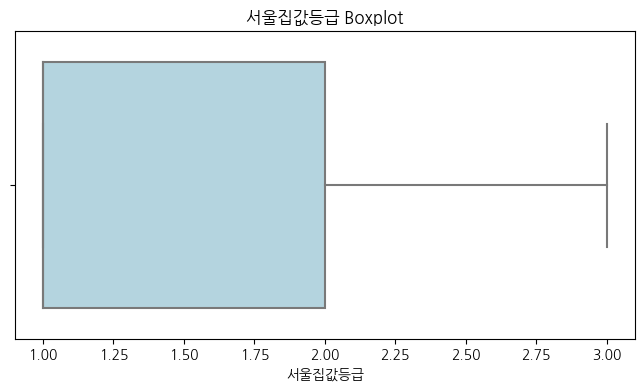

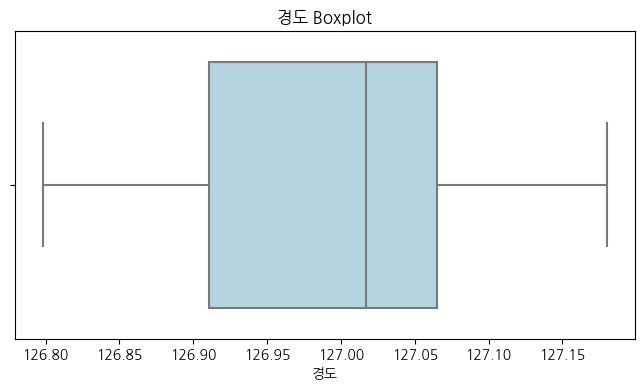

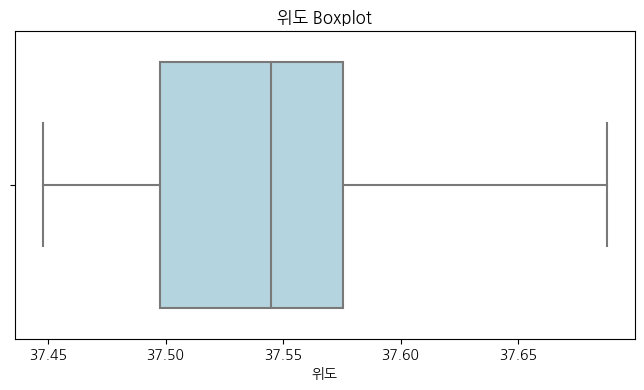

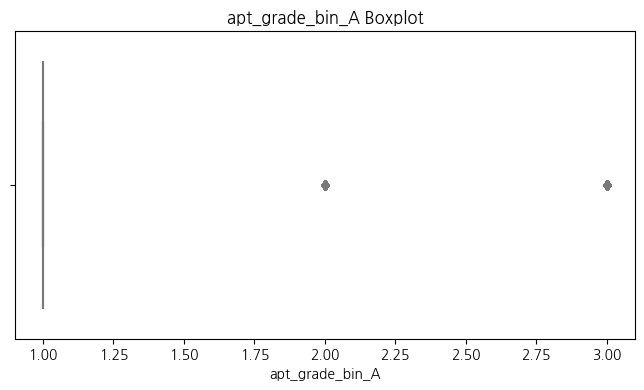

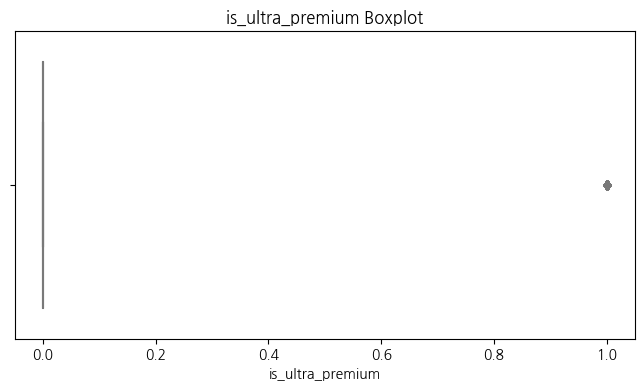

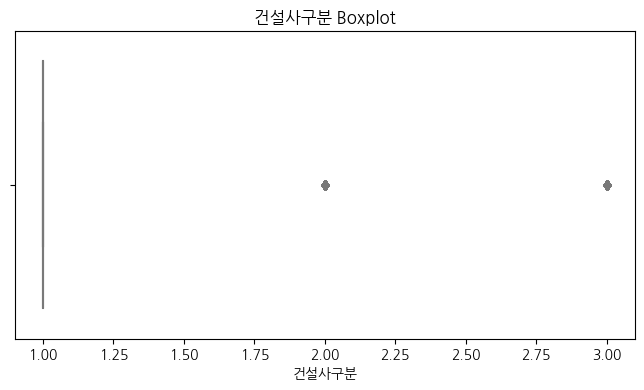

In [41]:
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 연속형 변수 시각화
for col in continuous_columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=train_main, x=col, color="lightblue")
    plt.title(f"{col} Boxplot")
    plt.show()

In [42]:
# 통계값 확인
train_main.describe()

,전용면적,계약일,층,건축년도,k-전체동수,k-전체세대수,k-연면적,건축면적,주차대수,target,...,소형비율,중소형비율,중대형비율,신축여부,서울집값등급,경도,위도,apt_grade_bin_A,is_ultra_premium,건설사구분
count,349288.000000,349288.000000,349288.000000,349288.000000,78020.000000,78409.000000,7.840900e+04,7.835700e+04,78359.000000,3.400150e+05,...,77882.000000,77882.000000,77882.000000,349288.000000,349288.000000,78364.000000,78364.000000,349288.0,349288.000000,349288.000000
mean,76.622583,15.781055,9.011581,1999.355715,15.303063,1256.476961,1.721216e+05,1.939772e+05,1179.034763,7.081302e+04,...,0.398989,0.425412,0.175147,0.166479,1.606004,126.996742,37.544673,1.347785,0.005534,1.127256
std,30.510418,8.689733,6.122243,9.940380,17.783271,1312.292548,2.122055e+05,1.835343e+06,1482.405416,5.732560e+04,...,0.332464,0.287096,0.233743,0.372510,0.787374,0.094324,0.052819,0.693009,0.074186,0.458696
min,10.156000,1.000000,-4.000000,1961.000000,1.000000,59.000000,0.000000e+00,0.000000e+00,0.000000,6.300000e+02,...,0.000000,0.000000,0.000000,0.000000,1.000000,126.798318,37.447843,1.0,0.000000,1.000000
25%,59.490000,8.000000,4.000000,1992.000000,5.000000,426.000000,5.626200e+04,0.000000e+00,329.000000,3.590000e+04,...,0.146953,0.244726,0.000000,0.000000,1.000000,126.910901,37.497741,1.0,0.000000,1.000000
50%,80.250000,16.000000,8.000000,2000.000000,10.000000,808.000000,1.048350e+05,2.620000e+03,717.000000,5.500000e+04,...,0.349127,0.427784,0.111531,0.000000,1.000000,127.016979,37.544854,1.0,0.000000,1.000000
75%,84.960000,23.000000,13.000000,2006.000000,19.000000,1656.000000,2.314400e+05,9.217770e+03,1353.000000,8.500000e+04,...,0.565401,0.598446,0.250000,0.000000,2.000000,127.064970,37.575524,1.0,0.000000,1.000000
max,395.060000,31.000000,69.000000,2023.000000,124.000000,9510.000000,9.591851e+06,3.159620e+07,12096.000000,1.450000e+06,...,1.000000,1.000000,1.000000,1.000000,3.000000,127.179998,37.687725,3.0,1.000000,3.000000


In [43]:
# 결측치 0으로 채우기
cols = [
    "층",
    "k-전체동수",
    "k-전체세대수",
    "k-연면적",
    "전용면적",
    "주차대수",
    '건축면적'
]
train_main[col].fillna(0, inplace=True)


In [44]:
# 0이상인 수치형 변수들에 log1p 변환 적용
log_cols = [
    "층",
    "k-전체동수",
    "k-전체세대수",
    "k-연면적",
    "전용면적",
    "주차대수",
    '건축면적'
]

# 새로운 컬럼명은 _log를 붙여서 추가
for col in log_cols:
    if col in train_main.columns:
        # 음수/0 방지: 0보다 작은 값은 0으로 클리핑 후 log1p 적용
        train_main[col + "_log"] = np.log1p(train_main[col].clip(lower=0))

In [45]:
# 로그 변환한 컬럼 리스트
log_cols = [
    "층_log",
    "k-전체동수_log",
    "k-전체세대수_log",
    "k-연면적_log",
    "전용면적_log",
    "주차대수_log",
    "건축면적_log"
]

# 0값 비율 확인
zero_check = {}
for col in log_cols:
    if col in train_main.columns:
        zero_ratio = (train_main[col] == 0).mean()
        zero_count = (train_main[col] == 0).sum()
        zero_check[col] = {"zero_count": zero_count, "zero_ratio": round(zero_ratio, 4)}

zero_report = pd.DataFrame(zero_check).T.sort_values("zero_ratio", ascending=False)
print("로그 변환 컬럼별 0값 현황")
display(zero_report)

로그 변환 컬럼별 0값 현황


,zero_count,zero_ratio
건축면적_log,34848.0,0.0998
주차대수_log,5662.0,0.0162
k-연면적_log,389.0,0.0011
층_log,70.0,0.0002
k-전체동수_log,0.0,0.0000
k-전체세대수_log,0.0,0.0000
전용면적_log,0.0,0.0000


In [46]:
# 로그변환한 컬럼 제외한 기존 컬럼 제거
train_main.drop(cols, axis=1, inplace=True)

In [47]:
# 통계값 확인
train_main.describe()

,계약일,건축년도,target,train_data,계약년,계약월,소형비율,중소형비율,중대형비율,신축여부,...,apt_grade_bin_A,is_ultra_premium,건설사구분,층_log,k-전체동수_log,k-전체세대수_log,k-연면적_log,전용면적_log,주차대수_log,건축면적_log
count,349288.000000,349288.000000,3.400150e+05,349288.000000,349288.000000,349288.000000,77882.000000,77882.000000,77882.000000,349288.000000,...,349288.0,349288.000000,349288.000000,349288.000000,78020.000000,78409.000000,78409.000000,349288.000000,78359.000000,78357.000000
mean,15.781055,1999.355715,7.081302e+04,0.973455,2016.706360,6.379535,0.398989,0.425412,0.175147,0.166479,...,1.347785,0.005534,1.127256,2.106088,2.393439,6.724089,11.546892,4.272502,6.100985,5.131963
std,8.689733,9.940380,5.732560e+04,0.160751,4.771687,3.396724,0.332464,0.287096,0.233743,0.372510,...,0.693009,0.074186,0.458696,0.660945,0.880976,0.908664,1.257809,0.417573,2.115735,4.751008
min,1.000000,1961.000000,6.300000e+02,0.000000,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,1.000000,0.000000,0.693147,4.094345,0.000000,2.411977,0.000000,0.000000
25%,8.000000,1992.000000,3.590000e+04,1.000000,2012.000000,3.000000,0.146953,0.244726,0.000000,0.000000,...,1.0,0.000000,1.000000,1.609438,1.791759,6.056784,10.937792,4.102478,5.799093,0.000000
50%,16.000000,2000.000000,5.500000e+04,1.000000,2018.000000,6.000000,0.349127,0.427784,0.111531,0.000000,...,1.0,0.000000,1.000000,2.197225,2.397895,6.695799,11.560153,4.397531,6.576470,7.871311
75%,23.000000,2006.000000,8.500000e+04,1.000000,2020.000000,9.000000,0.565401,0.598446,0.250000,0.000000,...,1.0,0.000000,1.000000,2.639057,2.995732,7.412764,12.352080,4.453882,7.210818,9.128997
max,31.000000,2023.000000,1.450000e+06,1.000000,2023.000000,12.000000,1.000000,1.000000,1.000000,1.000000,...,3.0,1.000000,3.000000,4.248495,4.828314,9.160204,16.076425,5.981566,9.400713,17.268547


In [48]:
# 로그변환한 컬럼 value 확인
train_main['건축면적_log'].value_counts()

0.000000     34848
10.155724      883
12.057410      864
10.805018      804
9.926169       739
             ...  
8.727888         2
6.951916         2
7.910393         2
8.753149         2
7.975956         1
Name: 건축면적_log, Length: 455, dtype: int64

In [49]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

세대전기계약방법               274069
청소비관리형태                271447
k-건설사(시공사)             271410
경비비관리형태                271407
소형비율                   271406
중대형비율                  271406
중소형비율                  271406
k-단지분류(아파트,주상복합등등)     271299
k-전체동수_log             271268
단지승인일                  271229
k-복도유형                 271017
건축면적_log               270931
주차대수_log               270929
k-사용검사일-사용승인일          270925
경도                     270924
위도                     270924
단지신청일                  270908
기타/의무/임대/임의=1/2/3/4    270880
k-연면적_log              270879
k-전체세대수_log            270879
k-난방방식                 270879
k-관리방식                 270879
k-세대타입(분양형태)           270879
target                   9273
is_ultra_premium            0
전용면적_log                    0
층_log                       0
건설사구분                       0
서울집값등급                      0
apt_grade_bin_A             0
신축여부                        0
동                           0
구                           0
건축년도      

In [50]:
# 결측치가 많은 '건축면적_log' 컬럼 제거
train_main.drop('건축면적_log', axis=1, inplace=True)

In [51]:
# 0값 비율 확인
all = list(train_main['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)

In [52]:
# 강남여부 변수 생성
is_gangnam = []
for x in train_main['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
train_main['강남여부'] = is_gangnam

In [53]:
# 신축여부 변수 생성
train_main['신축여부'] = train_main['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [54]:
# 버스 데이터 확인
bus.head(1)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


In [55]:
# 지하철 데이터 확인
subway.head(1)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877


In [56]:
# columns 이름 변경
bus.columns = ['노드ID', '정류소번호', '정류소명', '경도', '위도', '정류소 타입' ]

In [57]:
train_main.columns

Index(['계약일', '건축년도', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법',
       '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일', 'target',
       'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '구', '동', '신축여부',
       '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분',
       '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log',
       '주차대수_log', '강남여부'],
      dtype='object')

In [58]:
# 위도, 경도 좌표계산 (BallTree)
from sklearn.neighbors import BallTree

# ===== 파라미터 =====
BUS_LIMIT_M = 300          # 500~800m 중 네가 원하는 값으로 변경
EARTH_RADIUS_KM = 6371.0

# ===== 입력 =====
# train: 집 좌표가 들어있는 DF, 컬럼명 예시 ['위도','경도']
# subway: 지하철역 DF, 컬럼명 예시 ['역사명','위도','경도']
# 결측/비정상 좌표 제거 (선택)
train_ = train_main.dropna(subset=['위도','경도']).copy()
bus_ = bus.dropna(subset=['위도','경도']).copy()

# ===== 라디안 변환 =====
train_coords_rad  = np.radians(train_[['위도','경도']].values)
bus_coords_rad = np.radians(bus_[['위도','경도']].values)

# ===== BallTree (하버사인) =====
tree = BallTree(bus_coords_rad, metric='haversine')

# 반경(m) -> 라디안
radius_rad = (BUS_LIMIT_M / 1000.0) / EARTH_RADIUS_KM

# 반경 내 존재 여부 (binary)
inside_indices = tree.query_radius(train_coords_rad, r=radius_rad)
train_['bus_nearby'] = [1 if len(idxs) > 0 else 0 for idxs in inside_indices]

# 가장 가까운 지하철역까지의 거리(미터) & 이름(옵션)
# BallTree.query 반환 거리 단위: 라디안 -> m 로 변환
dist_rad, ind = tree.query(train_coords_rad, k=1)
nearest_dist_m = dist_rad[:, 0] * EARTH_RADIUS_KM * 1000.0
nearest_idx = ind[:, 0]

train_['nearest_bus_dist_m'] = nearest_dist_m.round(1)
train_['nearest_bus_name'] = bus_.iloc[nearest_idx]['정류소명'].values


train_main[['bus_nearby','nearest_bus_dist_m','nearest_bus_name']] = \
    train_.reindex(train_main.index)[['bus_nearby','nearest_bus_dist_m','nearest_bus_name']]



In [59]:
# ===== 파라미터 =====
SUBWAY_LIMIT_M = 800
EARTH_RADIUS_KM = 6371.0

# ===== 좌표 숫자화 & 결측 제거 =====
for df in (train_main, subway):
    df[['위도','경도']] = df[['위도','경도']].apply(pd.to_numeric, errors='coerce')

train_  = train_main.dropna(subset=['위도','경도']).copy()
subway_ = subway.dropna(subset=['위도','경도']).copy()

# ===== 라디안 변환 (반드시 [위도, 경도] 순서) =====
train_coords_rad  = np.radians(train_[['위도','경도']].to_numpy())
subway_coords_rad = np.radians(subway_[['위도','경도']].to_numpy())

# ===== BallTree (haversine) =====
subway_tree = BallTree(subway_coords_rad, metric='haversine')

# 반경(m) -> 라디안
radius_rad = (SUBWAY_LIMIT_M / 1000.0) / EARTH_RADIUS_KM

# 반경 내 존재 여부 (binary)
inside_indices = subway_tree.query_radius(train_coords_rad, r=radius_rad)
train_['subway_nearby'] = np.fromiter((len(ix) > 0 for ix in inside_indices), dtype=int, count=len(train_))

# 가장 가까운 지하철역까지의 거리(미터) & 이름
# query 반환 거리는 라디안 -> 미터로 변환
dist_rad, ind = subway_tree.query(train_coords_rad, k=1)
nearest_dist_m = dist_rad[:, 0] * EARTH_RADIUS_KM * 1000.0
nearest_idx    = ind[:, 0]

train_['nearest_subway_dist_m'] = nearest_dist_m.round(1)
train_['nearest_subway_name']   = subway_.iloc[nearest_idx]['역사명'].to_numpy()

# ===== 원본 인덱스에 정렬해서 할당 =====
cols = ['subway_nearby','nearest_subway_dist_m','nearest_subway_name']
train_main[cols] = train_.reindex(train_main.index)[cols]

In [60]:
train_main


,계약일,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-건설사(시공사),k-사용검사일-사용승인일,경비비관리형태,...,k-연면적_log,전용면적_log,주차대수_log,강남여부,bus_nearby,nearest_bus_dist_m,nearest_bus_name,subway_nearby,nearest_subway_dist_m,nearest_subway_name
0,8,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
1,22,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
2,28,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.024994,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
3,3,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
4,8,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349283,19,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.450269,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
349284,25,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.449919,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
349285,27,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.631325,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
349286,2,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.453649,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내


In [61]:
# 계약년 value 확인
train_main['계약년'].value_counts()

2018    74792
2009    62760
2020    49795
2021    42548
2012    27867
2023    26806
2017    22970
2019    14306
2022    12021
2011    11245
2008     4178
Name: 계약년, dtype: int64

In [62]:
# 불필요한 변수 제거
train_main.drop(['k-사용검사일-사용승인일','k-건설사(시공사)','단지신청일','단지승인일','기타/의무/임대/임의=1/2/3/4','계약일','k-단지분류(아파트,주상복합등등)','k-세대타입(분양형태)','k-관리방식','경비비관리형태','세대전기계약방법',
                 '청소비관리형태'],axis=1, inplace=True)

In [63]:
train_main.columns

Index(['건축년도', 'k-복도유형', 'k-난방방식', 'target', 'train_data', '계약년', '계약월',
       '소형비율', '중소형비율', '중대형비율', '구', '동', '신축여부', '서울집값등급', '경도', '위도',
       'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log',
       'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부',
       'bus_nearby', 'nearest_bus_dist_m', 'nearest_bus_name', 'subway_nearby',
       'nearest_subway_dist_m', 'nearest_subway_name'],
      dtype='object')

In [64]:
train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349288 entries, 0 to 349287
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   건축년도                   349288 non-null  int64  
 1   k-복도유형                 78271 non-null   object 
 2   k-난방방식                 78409 non-null   object 
 3   target                 340015 non-null  float64
 4   train_data             349288 non-null  int64  
 5   계약년                    349288 non-null  int64  
 6   계약월                    349288 non-null  int64  
 7   소형비율                   77882 non-null   float64
 8   중소형비율                  77882 non-null   float64
 9   중대형비율                  77882 non-null   float64
 10  구                      349288 non-null  object 
 11  동                      349288 non-null  object 
 12  신축여부                   349288 non-null  int64  
 13  서울집값등급                 349288 non-null  float64
 14  경도                     78364 non-nul

In [65]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns= []
categorical_columns = []
for column in train_main.columns:
    if pd.api.types.is_numeric_dtype(train_main[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['건축년도', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부', 'bus_nearby', 'nearest_bus_dist_m', 'subway_nearby', 'nearest_subway_dist_m']
범주형 변수: ['k-복도유형', 'k-난방방식', '구', '동', 'nearest_bus_name', 'nearest_subway_name']


In [66]:
# 복제
train_origin = train_main.copy()

In [67]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

소형비율                     271406
중소형비율                    271406
중대형비율                    271406
k-전체동수_log               271268
k-복도유형                   271017
주차대수_log                 270929
nearest_subway_name      270924
위도                       270924
경도                       270924
bus_nearby               270924
nearest_bus_dist_m       270924
nearest_bus_name         270924
subway_nearby            270924
nearest_subway_dist_m    270924
k-난방방식                   270879
k-연면적_log                270879
k-전체세대수_log              270879
target                     9273
강남여부                          0
전용면적_log                      0
건축년도                          0
층_log                         0
건설사구분                         0
is_ultra_premium              0
서울집값등급                        0
신축여부                          0
동                             0
구                             0
계약월                           0
계약년                           0
train_data                    0
apt_grad

In [68]:
# 결측치 0으로 채우기  
# 일단 test 타겟값도 0으로 채우기
train_main = train_main.fillna(0)

In [69]:
# 최종 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

건축년도                     0
k-복도유형                   0
nearest_subway_dist_m    0
subway_nearby            0
nearest_bus_name         0
nearest_bus_dist_m       0
bus_nearby               0
강남여부                     0
주차대수_log                 0
전용면적_log                 0
k-연면적_log                0
k-전체세대수_log              0
k-전체동수_log               0
층_log                    0
건설사구분                    0
is_ultra_premium         0
apt_grade_bin_A          0
위도                       0
경도                       0
서울집값등급                   0
신축여부                     0
동                        0
구                        0
중대형비율                    0
중소형비율                    0
소형비율                     0
계약월                      0
계약년                      0
train_data               0
target                   0
k-난방방식                   0
nearest_subway_name      0
dtype: int64

In [70]:
# 최종 데이터프레임 복제
df = train_main.copy()

# 원본 컬럼 (질문에서 준 순서)
base_cols = [
    '건축년도','k-복도유형','k-난방방식','계약년','계약월','소형비율','중소형비율','중대형비율',
    '구','동','신축여부','서울집값등급','경도','위도','apt_grade_bin_A',
    'is_ultra_premium','건설사구분','층_log','k-전체동수_log','k-전체세대수_log',
    'k-연면적_log','전용면적_log','주차대수_log','강남여부','bus_nearby',
    'nearest_bus_dist_m','nearest_bus_name','subway_nearby',
    'nearest_subway_dist_m','nearest_subway_name','train_data','target'
]
# 실제 존재하는 것만 사용(안전)
base_cols = [c for c in base_cols if c in df.columns]
df = df[base_cols].copy()


In [71]:
# 인코딩 및 스케일링
# 파생
if {'계약년','건축년도'}.issubset(df.columns):
    df['건물연차'] = (df['계약년'] - df['건축년도']).clip(lower=0, upper=100)
else:
    df['건물연차'] = np.nan

if '계약월' in df.columns:
    df['계약월_sin'] = np.sin(2*np.pi*df['계약월']/12)
    df['계약월_cos'] = np.cos(2*np.pi*df['계약월']/12)
else:
    df['계약월_sin'] = np.nan
    df['계약월_cos'] = np.nan

# '동' → 빈도 인코딩 (고카디널리티 방지)
if '동' in df.columns:
    dong_freq = df['동'].value_counts(normalize=True)
    df['동_freq'] = df['동'].map(dong_freq).astype(float)
else:
    df['동_freq'] = np.nan

# 이름 컬럼 드랍
for c in ['nearest_bus_name','nearest_subway_name']:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


In [72]:
# shape 확인
# train, test 분리
df_test = df.query('train_data==0')
df_train = df.query('train_data==1')

df_train.drop(['train_data'], axis=1, inplace=True)
df_test.drop(['train_data'], axis=1, inplace= True)
df_train.shape, df_test.shape

((340016, 33), (9272, 33))

In [73]:
df_train

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.0,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,124000.0,30,-2.449294e-16,1.000000e+00,0.011280
1,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.0,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,123500.0,30,-2.449294e-16,1.000000e+00,0.011280
2,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.0,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,91500.0,30,-2.449294e-16,1.000000e+00,0.011280
3,1987,계단식,개별난방,2018,1,0.074074,0.925926,0.0,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,130000.0,31,5.000000e-01,8.660254e-01,0.011280
4,1987,계단식,개별난방,2018,1,0.074074,0.925926,0.0,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,117000.0,31,5.000000e-01,8.660254e-01,0.011280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340011,2016,복도식,개별난방,2020,8,1.000000,0.000000,0.0,동대문구,용두동,...,0,1.0,17.7,1.0,167.8,40000.0,4,-8.660254e-01,-5.000000e-01,0.002004
340012,2016,복도식,개별난방,2020,9,1.000000,0.000000,0.0,동대문구,용두동,...,0,1.0,17.7,1.0,167.8,40000.0,4,-1.000000e+00,-1.836970e-16,0.002004
340013,2016,복도식,개별난방,2020,9,1.000000,0.000000,0.0,동대문구,용두동,...,0,1.0,17.7,1.0,167.8,42900.0,4,-1.000000e+00,-1.836970e-16,0.002004
340014,2016,복도식,개별난방,2020,9,1.000000,0.000000,0.0,동대문구,용두동,...,0,1.0,17.7,1.0,167.8,39900.0,4,-1.000000e+00,-1.836970e-16,0.002004


In [74]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['건축년도', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부', 'bus_nearby', 'nearest_bus_dist_m', 'subway_nearby', 'nearest_subway_dist_m', 'target', '건물연차', '계약월_sin', '계약월_cos', '동_freq']
범주형 변수: ['k-복도유형', 'k-난방방식', '구', '동']


In [80]:
# 라벨 인코
label_encoders = {}
for col in categorical_columns_v2:
    df_train[col] = df_train[col].astype("string").fillna("__NA__")
    df_test[col]  = df_test[col].astype("string").fillna("__NA__")

    lbl = LabelEncoder()
    lbl.fit(pd.concat([df_train[col], df_test[col]], axis=0))

    df_train[col] = lbl.transform(df_train[col])
    df_test[col]  = lbl.transform(df_test[col])
    label_encoders[col] = lbl


In [81]:
# 잘 됐는지 확인
df_train[categorical_columns_v2].nunique()

k-복도유형      6
k-난방방식      5
구          25
동         336
dtype: int64

In [83]:
# 스케일링 표준화
df_std = df_train.copy()
df_test_std = df_test.copy()

In [84]:
# 표준화할 컬럼 리스트 (예시: num_cols)
num_cols = [
    '건물연차','계약월_sin','계약월_cos',
    '층_log','k-전체동수_log','k-전체세대수_log','k-연면적_log','전용면적_log','주차대수_log',
    '서울집값등급','소형비율','중소형비율','중대형비율',
    'nearest_bus_dist_m','nearest_subway_dist_m','동_freq'
]

# 원본 복사

# for문으로 각 컬럼 표준화
for col in num_cols:
    mean = df_std[col].mean()
    std = df_std[col].std()
    df_std[col] = (df_std[col] - mean) / std

for col in num_cols:
    mean = df_test_std[col].mean()
    std = df_test_std[col].std()
    df_test_std[col] = (df_test_std[col] - mean) / std

print(df_std[num_cols].head())

       건물연차  계약월_sin  계약월_cos     층_log  k-전체동수_log  k-전체세대수_log  k-연면적_log  \
0  1.270231 -0.03101  1.43142 -1.085224    1.549691     1.451889   1.541632   
1  1.270231 -0.03101  1.43142 -0.747524    1.549691     1.451889   1.541632   
2  1.270231 -0.03101  1.43142 -0.471603    1.549691     1.451889   1.541632   
3  1.370092  0.68482  1.24402 -0.747524    1.549691     1.451889   1.541632   
4  1.370092  0.68482  1.24402 -1.520595    1.549691     1.451889   1.541632   

   전용면적_log  주차대수_log    서울집값등급      소형비율     중소형비율     중대형비율  \
0  0.290214  1.548557  1.771749 -0.062036  3.743367 -0.294101   
1  0.290214  1.548557  1.771749 -0.062036  3.743367 -0.294101   
2 -0.593273  1.548557  1.771749 -0.062036  3.743367 -0.294101   
3  0.290214  1.548557  1.771749 -0.062036  3.743367 -0.294101   
4  0.290214  1.548557  1.771749 -0.062036  3.743367 -0.294101   

   nearest_bus_dist_m  nearest_subway_dist_m    동_freq  
0            0.572634               3.571795  0.071414  
1            0.57263

In [85]:
# Min-Max 스케일링
df_minmax = df_train.copy()
df_test_minmax = df_test.copy()

In [86]:
# 정규화할 컬럼 리스트 (예시: num_cols)
num_cols = [
    '건물연차','계약월_sin','계약월_cos',
    '층_log','k-전체동수_log','k-전체세대수_log','k-연면적_log','전용면적_log','주차대수_log',
    '서울집값등급','소형비율','중소형비율','중대형비율',
    'nearest_bus_dist_m','nearest_subway_dist_m','동_freq'
]




# for문으로 각 컬럼 정규화 (0~1 사이로 변환)
for col in num_cols:
    min_val = df_minmax[col].min()
    max_val = df_minmax[col].max()
    if max_val != min_val:  # 0으로 나누기 방지
        df_minmax[col] = (df_minmax[col] - min_val) / (max_val - min_val)
    else:
        df_minmax[col] = 0.0  # 값이 전부 같으면 0으로 처리
# 테스트 세트
for col in num_cols:
    min_val = df_test_minmax[col].min()
    max_val = df_test_minmax[col].max()
    if max_val != min_val:  # 0으로 나누기 방지
        df_test_minmax[col] = (df_test_minmax[col] - min_val) / (max_val - min_val)
    else:
        df_test_minmax[col] = 0.0  # 값이 전부 같으면 0으로 처리
print(df_minmax[num_cols].head())


       건물연차  계약월_sin   계약월_cos     층_log  k-전체동수_log  k-전체세대수_log  k-연면적_log  \
0  0.491803     0.50  1.000000  0.326302    0.455071     0.611571   0.623732   
1  0.491803     0.50  1.000000  0.378825    0.455071     0.611571   0.623732   
2  0.491803     0.50  1.000000  0.421740    0.455071     0.611571   0.623732   
3  0.508197     0.75  0.933013  0.378825    0.455071     0.611571   0.623732   
4  0.508197     0.75  0.933013  0.258589    0.455071     0.611571   0.623732   

   전용면적_log  주차대수_log  서울집값등급      소형비율     중소형비율  중대형비율  nearest_bus_dist_m  \
0  0.555274  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
1  0.555274  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
2  0.451878  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
3  0.555274  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
4  0.555274  0.592737     1.0  0.074074  0.925926    0.0            0.131154   

   nearest_subway_dist_m    동_freq  
0

In [87]:
df_std

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,1,1,2017,12,-0.062036,3.743367,-0.294101,0,8,...,1,1.0,0.572634,0.0,3.571795,124000.0,1.270231,-0.031010,1.431420,0.071414
1,1987,1,1,2017,12,-0.062036,3.743367,-0.294101,0,8,...,1,1.0,0.572634,0.0,3.571795,123500.0,1.270231,-0.031010,1.431420,0.071414
2,1987,1,1,2017,12,-0.062036,3.743367,-0.294101,0,8,...,1,1.0,0.572634,0.0,3.571795,91500.0,1.270231,-0.031010,1.431420,0.071414
3,1987,1,1,2018,1,-0.062036,3.743367,-0.294101,0,8,...,1,1.0,0.572634,0.0,3.571795,130000.0,1.370092,0.684820,1.244020,0.071414
4,1987,1,1,2018,1,-0.062036,3.743367,-0.294101,0,8,...,1,1.0,0.572634,0.0,3.571795,117000.0,1.370092,0.684820,1.244020,0.071414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340011,2016,3,1,2020,8,3.997271,-0.422567,-0.294101,10,231,...,0,1.0,-0.170692,1.0,0.151812,40000.0,-1.326146,-1.270863,-0.666738,-0.932898
340012,2016,3,1,2020,9,3.997271,-0.422567,-0.294101,10,231,...,0,1.0,-0.170692,1.0,0.151812,40000.0,-1.326146,-1.462669,0.032648,-0.932898
340013,2016,3,1,2020,9,3.997271,-0.422567,-0.294101,10,231,...,0,1.0,-0.170692,1.0,0.151812,42900.0,-1.326146,-1.462669,0.032648,-0.932898
340014,2016,3,1,2020,9,3.997271,-0.422567,-0.294101,10,231,...,0,1.0,-0.170692,1.0,0.151812,39900.0,-1.326146,-1.462669,0.032648,-0.932898


In [88]:
df_minmax

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,1,1,2017,12,0.074074,0.925926,0.0,0,8,...,1,1.0,0.131154,0.0,0.449994,124000.0,0.491803,0.500000,1.000000,0.262163
1,1987,1,1,2017,12,0.074074,0.925926,0.0,0,8,...,1,1.0,0.131154,0.0,0.449994,123500.0,0.491803,0.500000,1.000000,0.262163
2,1987,1,1,2017,12,0.074074,0.925926,0.0,0,8,...,1,1.0,0.131154,0.0,0.449994,91500.0,0.491803,0.500000,1.000000,0.262163
3,1987,1,1,2018,1,0.074074,0.925926,0.0,0,8,...,1,1.0,0.131154,0.0,0.449994,130000.0,0.508197,0.750000,0.933013,0.262163
4,1987,1,1,2018,1,0.074074,0.925926,0.0,0,8,...,1,1.0,0.131154,0.0,0.449994,117000.0,0.508197,0.750000,0.933013,0.262163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340011,2016,3,1,2020,8,1.000000,0.000000,0.0,10,231,...,0,1.0,0.037564,1.0,0.066834,40000.0,0.065574,0.066987,0.250000,0.046522
340012,2016,3,1,2020,9,1.000000,0.000000,0.0,10,231,...,0,1.0,0.037564,1.0,0.066834,40000.0,0.065574,0.000000,0.500000,0.046522
340013,2016,3,1,2020,9,1.000000,0.000000,0.0,10,231,...,0,1.0,0.037564,1.0,0.066834,42900.0,0.065574,0.000000,0.500000,0.046522
340014,2016,3,1,2020,9,1.000000,0.000000,0.0,10,231,...,0,1.0,0.037564,1.0,0.066834,39900.0,0.065574,0.000000,0.500000,0.046522


In [89]:
# shape 확인
assert df_std.shape[1] == df_test_std.shape[1]
assert df_minmax.shape[1] == df_test_minmax.shape[1]

In [90]:
# target 있는 데이터만 사용
mask = df_std['target'].notna()
df_train = df_std[mask].copy()

X = df_train.drop(columns=['target'])  # 또는 num_cols+cat_cols 같은 feature set
y = df_train['target']

In [91]:
# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2 , random_state=42)

In [92]:
# --- 0) 필요 라이브러리 ---
import lightgbm as lgb
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# (선택) 네가 앞서 만든 평가 함수가 없다면 주석 해제해서 사용
from sklearn import metrics
def evaluate_regression(model, X_train, y_train, X_val, y_val):
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)
    import sklearn.metrics as M
    mae_tr  = M.mean_absolute_error(y_train, pred_tr)
    rmse_tr = np.sqrt(M.mean_squared_error(y_train, pred_tr))
    r2_tr   = M.r2_score(y_train, pred_tr)     
    err_tr  = rmse_tr / (np.mean(y_train) + 1e-12)
    mae_va  = M.mean_absolute_error(y_val, pred_va)
    rmse_va = np.sqrt(M.mean_squared_error(y_val, pred_va))
    r2_va   = M.r2_score(y_val, pred_va)
    err_va  = rmse_va / (np.mean(y_val) + 1e-12)
    print(f"Train R2={r2_tr:.4f} RMSE={rmse_tr:,.4f} MAE={mae_tr:,.4f} Err={err_tr:.2%}")
    print(f"Valid R2={r2_va:.4f} RMSE={rmse_va:,.4f} MAE={mae_va:,.4f} Err={err_va:.2%}")
    return {"train": {"R2": r2_tr, "RMSE": rmse_tr, "MAE": mae_tr, "Err": err_tr},
           "valid": {"R2": r2_va, "RMSE": rmse_va, "MAE": mae_va, "Err": err_va}}

# --- 1) 범주형 컬럼 인덱스 지정 (라벨 인코딩된 정수여야 함) ---
# 예: categorical_columns_v2 = ['k-난방방식','구','동']
cat_idx = [X_train.columns.get_loc(c) for c in categorical_columns_v2 if c in X_train.columns]

# --- 2) 콜백(조기 종료/로그) ---
callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=False),
    lgb.log_evaluation(period=100)
]

# --- 3) 모델 정의 ---
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=5000,      # 크게 두고 early stopping으로 최적 라운드 사용
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,          # bagging_fraction
    colsample_bytree=0.8,   # feature_fraction
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

# --- 4) 학습 ---
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=callbacks,
    categorical_feature=cat_idx  # 범주형 컬럼 인덱스 전달
)

# --- 5) 평가 ---
results = evaluate_regression(lgbm, X_train, y_train, X_val, y_val)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3480
[LightGBM] [Info] Number of data points in the train set: 272012, number of used features: 32
[LightGBM] [Info] Start training from score 70842.231828
[100]	valid_0's rmse: 15453.1	valid_0's l2: 2.38799e+08
[200]	valid_0's rmse: 12452.5	valid_0's l2: 1.55065e+08
[300]	valid_0's rmse: 11455.2	valid_0's l2: 1.31222e+08
[400]	valid_0's rmse: 10924	valid_0's l2: 1.19334e+08
[500]	valid_0's rmse: 10557.4	valid_0's l2: 1.11459e+08
[600]	valid_0's rmse: 10311.7	valid_0's l2: 1.0633e+08
[700]	valid_0's rmse: 10114	valid_0's l2: 1.02293e+08
[800]	valid_0's rmse: 9963.13	valid_0's l2: 9.9264e+07
[900]	valid_0's rmse: 9841.28	valid_0's l2: 9.68508e+07
[1000]	valid_0's rmse: 9742.96	valid_0's l2: 9.49252e+07
[1100]	valid_0's rmse: 9653.18	val

In [120]:
results

{'train': {'R2': 0.9873405465545674,
  'RMSE': 5217.31619936859,
  'MAE': 2989.3236817519714,
  'Err': 0.08994863806107603},
 'valid': {'R2': 0.980397847521909,
  'RMSE': 6531.107460475125,
  'MAE': 3281.157817005719,
  'Err': 0.11271309017547043}}

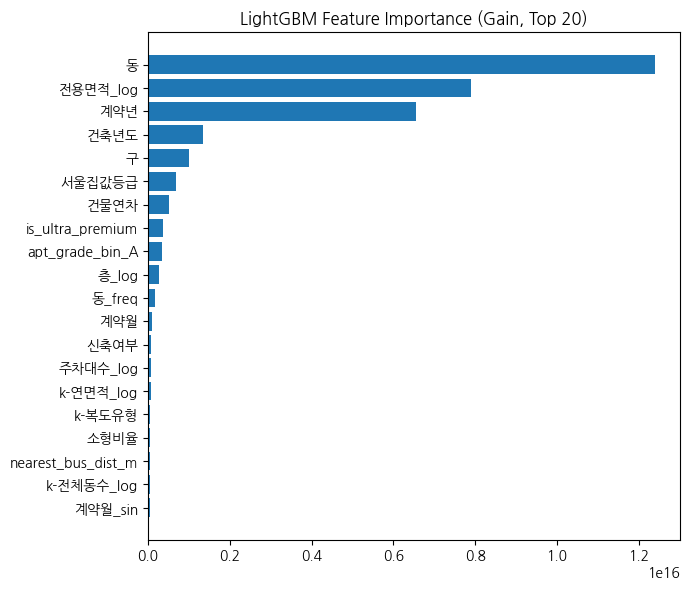

In [113]:
# 한글 폰트 설정
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
imp = pd.DataFrame({
    "feature": lgbm.feature_name_,
    "gain": lgbm.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(7,6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("LightGBM Feature Importance (Gain, Top 20)")
plt.tight_layout(); plt.show()

In [117]:
# 랜덤포레스트 모델 학습
model = RandomForestRegressor(n_estimators=500,criterion='squared_error',random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [118]:
from sklearn import metrics
import numpy as np

def evaluate_regression(model, X_train, y_train, X_val, y_val,
                        overfit_gap=0.10,         # R² 차이 기준 (train - val)
                        rmse_ratio_thr=1.50,      # RMSE 비율 기준 (val/train)
                        good_r2=0.80,             # 충분히 높은 R² 기준
                        low_r2=0.60,              # 낮은 R² 기준 (과소적합 의심)
                        high_err_rate=0.20        # 높은 오차율 기준 (RMSE / mean(y))
                       ):
    """
    회귀 모델 성능 평가 + 과적합/과소적합 진단
    - 지표: R², MAE, RMSE, 평균대비오차율(RMSE/mean(y))
    - 진단 규칙(기본):
        • 과적합: R²_gap >= 0.10 또는 RMSE 비율 >= 1.50 이면서 train R²는 충분히 높음
        • 과소적합: train/val R² 둘 다 낮거나, 오차율이 높고 두 세트 성능이 모두 안 좋음
        • 정상/양호: 위 두 조건이 아니면
    """

    # ---- 예측 ----
    pred_train = model.predict(X_train)
    pred_val   = model.predict(X_val)

    # ---- 훈련 지표 ----
    mae_train  = metrics.mean_absolute_error(y_train, pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    r2_train   = metrics.r2_score(y_train, pred_train)
    err_train  = rmse_train / (np.mean(y_train) + 1e-12)

    # ---- 검증 지표 ----
    mae_val  = metrics.mean_absolute_error(y_val, pred_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, pred_val))
    r2_val   = metrics.r2_score(y_val, pred_val)
    err_val  = rmse_val / (np.mean(y_val) + 1e-12)

    # ---- 진단 지표 ----
    r2_gap        = max(0.0, r2_train - r2_val)
    rmse_ratio    = (rmse_val / (rmse_train + 1e-12))

    # ---- 과적합/과소적합 판정 ----
    is_overfit = (r2_train >= good_r2) and ((r2_gap >= overfit_gap) or (rmse_ratio >= rmse_ratio_thr))
    is_underfit = ((r2_train < low_r2) and (r2_val < low_r2)) or ((err_train >= high_err_rate) and (err_val >= high_err_rate))

    if is_overfit and not is_underfit:
        diagnosis = "overfitting"
    elif is_underfit and not is_overfit:
        diagnosis = "underfitting"
    elif is_overfit and is_underfit:
        diagnosis = "inconclusive (both symptoms)"  # 드문 케이스
    else:
        diagnosis = "well-fit"

    # ---- 출력 ----
    print("=== 훈련 세트 성능 ===")
    print(f"R²        : {r2_train:.4f}")
    print(f"MAE       : {mae_train:,.4f}")
    print(f"RMSE      : {rmse_train:,.4f}")
    print(f"오차율    : {err_train:.4%}")

    print("\n=== 검증 세트 성능 ===")
    print(f"R²        : {r2_val:.4f}")
    print(f"MAE       : {mae_val:,.4f}")
    print(f"RMSE      : {rmse_val:,.4f}")
    print(f"오차율    : {err_val:.4%}")

    print("\n=== 진단 보조 지표 ===")
    print(f"R² gap (train - val) : {r2_gap:.4f}")
    print(f"RMSE ratio (val/train): {rmse_ratio:.3f}")
    print(f"\n>>> Diagnosis: {diagnosis}")

    return {
        "train": {"R2": r2_train, "MAE": mae_train, "RMSE": rmse_train, "ErrorRate": err_train},
        "valid": {"R2": r2_val, "MAE": mae_val, "RMSE": rmse_val, "ErrorRate": err_val},
        "diagnostics": {"R2_gap": r2_gap, "RMSE_ratio": rmse_ratio, "diagnosis": diagnosis},
        "thresholds": {
            "overfit_gap": overfit_gap,
            "rmse_ratio_thr": rmse_ratio_thr,
            "good_r2": good_r2,
            "low_r2": low_r2,
            "high_err_rate": high_err_rate
        }
    }

# 사용 예시
model.fit(X_train, y_train)
results = evaluate_regression(model, X_train, y_train, X_val, y_val)


=== 훈련 세트 성능 ===
R²        : 0.9966
MAE       : 1,224.3258
RMSE      : 2,701.0530
오차율    : 4.6567%

=== 검증 세트 성능 ===
R²        : 0.9758
MAE       : 3,183.4529
RMSE      : 7,259.6443
오차율    : 12.5286%

=== 진단 보조 지표 ===
R² gap (train - val) : 0.0208
RMSE ratio (val/train): 2.688

>>> Diagnosis: overfitting
